# Introduction

https://www.because-security.com/blog/advanced-practitioners-guide-to-byte-level-transformation-dec-2024 

### Load the config

The `config.json` is in the .gitignore file. It's not in the repo.

The structure is as follows:
```json
{
    "huggingface_token": "hf...",
    "data_path": "~/source/datasets/log2ml/lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_with_vectors_clean.parquet",
    "blt_dir": "~/source/projects/infosec_ml_rnd/bpe_vs_blt_log_vec/blt"
}
```

You probably need to change the paths to your own. And add the OpenAI token if you want to use OpenAI embeddings.

In [1]:
import importlib
import blt_wrapper.blt_wrapper  # Import the full module first

# Reload the module to refresh it after code changes
importlib.reload(blt_wrapper.blt_wrapper)

# Re-import the function (Python has persitent imports anyway, especially in Jupyter)
from blt_wrapper.blt_wrapper import load_config
hf_token, blt_dir = load_config("config.json")

## Hands on Byte Level Transformers

### BLT = Byte Level Transformer

The following parts work with the new research code from Meta. It's verbose code, but that's in the nature of ML if you look behind the scenes.



You need your Huggingface token, and you need it now.

In [2]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import dl_blt_tokenizer
from blt_wrapper.blt_wrapper import load_blt_lib


# pass the loaded HF token
dl_blt_tokenizer(hf_token)
load_blt_lib(blt_dir)

Successfully downloaded tokenizer to: tokenizers\tokenizer.model
Loading from blt_dir: C:\Users\mariu\source\projects\infosec_ml_rnd\bpe_vs_blt_log_vec\blt
BLT imports successful!


In [3]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_tokenizers

init_and_test_tokenizers()


Tokenizers initialized successfully!

Test results:
Original text: Hello, this is a test.
BPE tokens: [1, 15043, 29892, 445, 338, 263, 1243, 29889, 2]
BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 50, 2]
Sentence length:    22
BPE tokens created: 9
BLT tokens created: 31


Observation: BLT tokens here (this is the first step) are longer.

### What about the Patches?

There are

- Entropy based patches
- BPE based patches
- Space

In [4]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_byte_patcher

init_and_test_byte_patcher()



Byte Patcher initialized successfully!

Byte Patcher test results:
Original data length: 71 bytes
Batch shape: torch.Size([1, 71])
Number of patches: 9
Patch 0: Length=8, Data=b'Hello Wo'
Patch 1: Length=8, Data=b'rld! Thi'
Patch 2: Length=8, Data=b's is som'
Patch 3: Length=8, Data=b'e test b'
Patch 4: Length=8, Data=b'inary da'
Patch 5: Length=8, Data=b'ta with '
Patch 6: Length=8, Data=b'varying '
Patch 7: Length=8, Data=b'entropy '
Patch 8: Length=7, Data=b'levels.'


(<bytelatent.data.patcher.Patcher at 0x1d3a1cdf730>,
 tensor([[8, 8, 8, 8, 8, 8, 8, 8, 7]]))

In [5]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import init_and_test_bpe_patcher

init_and_test_bpe_patcher()



BPE Patcher initialized successfully!

BPE Patcher test results:
Original text: Hello, this is a test for BPE patching!
BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 36, 106, 115, 118, 3, 36, 70, 3, 84, 73, 3, 36, 116, 101, 120, 103, 108, 3, 109, 114, 107, 3, 37, 2]
Patch lengths: [[1, 1, 6, 2, 6, 4, 3, 6, 5, 3, 3, 7, 4, 2]]
Patch 0: Length=1, Tokens=[1]
Patch 1: Length=1, Tokens=[3]
Patch 2: Length=6, Tokens=[76, 105, 112, 112, 115, 3]
Patch 3: Length=2, Tokens=[48, 3]
Patch 4: Length=6, Tokens=[36, 120, 108, 109, 119, 3]
Patch 5: Length=4, Tokens=[36, 109, 119, 3]
Patch 6: Length=3, Tokens=[36, 101, 3]
Patch 7: Length=6, Tokens=[36, 120, 105, 119, 120, 3]
Patch 8: Length=5, Tokens=[36, 106, 115, 118, 3]
Patch 9: Length=3, Tokens=[36, 70, 3]
Patch 10: Length=3, Tokens=[84, 73, 3]
Patch 11: Length=7, Tokens=[36, 116, 101, 120, 103, 108, 3]
Patch 12: Length=4, Tokens=[109, 114, 107, 3]
Patch 13: L

(<bytelatent.data.patcher.Patcher at 0x1d3a1ed95a0>,
 tensor([[1, 1, 6, 2, 6, 4, 3, 6, 5, 3, 3, 7, 4, 2]]),
 [1,
  3,
  76,
  105,
  112,
  112,
  115,
  3,
  48,
  3,
  36,
  120,
  108,
  109,
  119,
  3,
  36,
  109,
  119,
  3,
  36,
  101,
  3,
  36,
  120,
  105,
  119,
  120,
  3,
  36,
  106,
  115,
  118,
  3,
  36,
  70,
  3,
  84,
  73,
  3,
  36,
  116,
  101,
  120,
  103,
  108,
  3,
  109,
  114,
  107,
  3,
  37,
  2])

There are differences. Longer sequences (first step), which has an implication of Attention for the models.

## From BLT Patches to BLT Transformer Embeddings

In [6]:
import importlib
import blt_wrapper.blt_wrapper  

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import create_blt_model, get_model_hidden_states, make_blt_embeddings
from pathlib import Path

# Create model and test embeddings
tokenizer_path = Path("tokenizers/tokenizer.model")
model = create_blt_model()
test_text = "Hello, this is a test."

hidden_states = get_model_hidden_states(test_text, model, tokenizer_path, verbose=True)
embeddings = make_blt_embeddings()

Initializing model with:
- Model dimension: 1024
- Number of heads: 16
Creating model...
Model initialized successfully on cuda

=== Analyzing Model Hidden States ===
Input text: 'Hello, this is a test.'

Base output shape: torch.Size([1, 31, 1024])
Final output shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Hidden dimension: 1024
• Device: cuda:0
• Dtype: torch.float16

Statistics:
• Mean: -0.000
• Std: 0.335
• Min: -1.280
• Max: 1.358

Value Distribution:
• 0th percentile: -1.280
• 25th percentile: -0.227
• 50th percentile: -0.000
• 75th percentile: 0.226
• 100th percentile: 1.358
Initializing model with:
- Model dimension: 1024
- Number of heads: 16
Creating model...
Model initialized successfully on cuda

=== BLT Embedding Analysis ===

Input Text: "Hello, this is a test."

=== TOKEN Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Embedding dimension: 1024
• Parameters: 31,744
• Share of total: 33.33%

Statistics:
• 

In [7]:
for emb in embeddings:
    print(emb)

token
position
final


In [8]:
print(hidden_states.shape)

torch.Size([1, 31, 1024])


In [38]:
import importlib
import blt_wrapper.blt_wrapper  
from transformers import AutoTokenizer
import time

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import make_blt_embeddings

# Measure execution time
start_time = time.time()
blt_embedding = make_blt_embeddings()
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Initializing model with:
- Model dimension: 1024
- Number of heads: 16
Creating model...
Model initialized successfully on cuda

=== BLT Embedding Analysis ===

Input Text: "Hello, this is a test."

=== TOKEN Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Embedding dimension: 1024
• Parameters: 31,744
• Share of total: 33.33%

Statistics:
• Mean: 0.012
• Std: 0.576
• Min: -2.258
• Max: 2.223

=== POSITION Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Embedding dimension: 1024
• Parameters: 31,744
• Share of total: 33.33%

Statistics:
• Mean: 0.012
• Std: 0.576
• Min: -2.258
• Max: 2.223

=== FINAL Embeddings ===
Shape: torch.Size([1, 31, 1024])
• Batch size: 1
• Sequence length: 31
• Embedding dimension: 1024
• Parameters: 31,744
• Share of total: 33.33%

Statistics:
• Mean: 0.012
• Std: 0.576
• Min: -2.258
• Max: 2.223

=== Overall Statistics ===
Total parameters across all embeddings: 95,232
Execution 

In [13]:
print(test_text)
print(blt_embedding)

Hello, this is a test.
{'token': tensor([[[-0.0997, -0.6650, -1.4316,  ..., -0.5781, -0.4795,  0.1780],
         [-0.1432, -0.3591,  0.1537,  ..., -0.6191,  0.0714,  0.3655],
         [-0.1155, -0.2183,  0.1476,  ..., -0.2012, -0.3140, -0.0785],
         ...,
         [ 0.7427, -0.9854,  0.4656,  ..., -0.1980,  0.5532, -0.2932],
         [ 0.0682, -0.7256, -0.5703,  ...,  0.0202,  0.5557,  0.4434],
         [-0.7593, -0.2017,  0.3518,  ..., -0.2189,  0.9170, -0.0031]]],
       device='cuda:0'), 'position': tensor([[[-0.0997, -0.6650, -1.4316,  ..., -0.5781, -0.4795,  0.1780],
         [-0.1432, -0.3591,  0.1537,  ..., -0.6191,  0.0714,  0.3655],
         [-0.1155, -0.2183,  0.1476,  ..., -0.2012, -0.3140, -0.0785],
         ...,
         [ 0.7427, -0.9854,  0.4656,  ..., -0.1980,  0.5532, -0.2932],
         [ 0.0682, -0.7256, -0.5703,  ...,  0.0202,  0.5557,  0.4434],
         [-0.7593, -0.2017,  0.3518,  ..., -0.2189,  0.9170, -0.0031]]],
       device='cuda:0'), 'final': tensor([[[-0

## Linformer Embeddings with Byte-Pair-Encoding

In [39]:
import importlib
import blt_wrapper.blt_wrapper  
import time

# Same pattern of refreshing
importlib.reload(blt_wrapper.blt_wrapper)
from blt_wrapper.blt_wrapper import get_linformer_embedding
from pathlib import Path

test_text = "Hello, this is a test."

# Measure execution time
start_time = time.time()
linformer_embedding = get_linformer_embedding(test_text)
end_time = time.time()

print(f"Execution time: {end_time - start_time:.2f} seconds")


Initializing Linformer model...
Using GPU: NVIDIA GeForce GTX 1650
Execution time: 3.18 seconds


In [15]:
print(test_text)
print(linformer_embedding.shape)
print(linformer_embedding)

Hello, this is a test.
(1024,)
[ 8.106748  -4.744223  -2.4028153 ... -4.2454567 -7.1888247 15.412267 ]


## BLT and BPE on Sysmon telemetry

*Sysmon telemetry* here refers to observed data, which has been generated in a lab. The dataset contains no malicious data, no personal information, and no sensitive data. It's from a lab environment, which I hosted for my thesis. No employer data, no client data, no nothing :) 

In [17]:
import importlib
import data_manager.data_manager

# Same pattern of refreshing
importlib.reload(data_manager.data_manager)
from data_manager.data_manager import load_filtered_messages

messages_df = load_filtered_messages()
messages_df

,filtered_message
0,Network connection detected: \nRuleName: -\nPr...
1,Network connection detected: \nRuleName: -\nPr...
2,Process accessed: \nRuleName: -\nSourceProcess...
3,Process accessed: \nRuleName: -\nSourceProcess...
4,Process accessed: \nRuleName: -\nSourceProcess...
...,...
13450,Process accessed: \nRuleName: -\nSourceProcess...
13451,Process accessed: \nRuleName: -\nSourceProcess...
13452,Process accessed: \nRuleName: -\nSourceProcess...
13453,Process accessed: \nRuleName: -\nSourceProcess...


The creation of Embeddings can be a time-consuming / computation-heavy process.

We want to do this one time only. In the past, I relied on parquet files, but this has been complex at times due to sparse high-dimensionality of the embeddings of the dataset. *DuckDB* is a new alternative. Parquet isn't perfect for vector data.

In [18]:
# First we load the data from DuckDB
# The code stets the version of the underlying ML stack

import numpy as np
import pandas as pd
import duckdb

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("DuckDB version:", duckdb.__version__ if hasattr(duckdb, '__version__') else 'Unknown')

NumPy version: 2.1.3
Pandas version: 2.2.3
DuckDB version: 1.1.3


The Silhouette Score can be calculated using scikit-learn's KMeans clustering.

In [25]:
import duckdb
import numpy as np

# Create a new connection
con = duckdb.connect('embeddings_1k.duckdb')

# Diagnostic code
query = """
SELECT
    embedding_blt::DOUBLE[] as blt_embedding,
    embedding_bpe::DOUBLE[] as bpe_embedding
FROM message_embeddings
LIMIT 5
"""
sample_data = con.execute(query).fetchdf()

# Check shapes and basic statistics
print("Sample sizes:")
print("BPE shape:", np.stack(sample_data['bpe_embedding'].values).shape)
print("BLT shape:", np.stack(sample_data['blt_embedding'].values).shape)

# Check for NaN or inf values
bpe_vectors = np.stack(sample_data['bpe_embedding'].values)
blt_vectors = np.stack(sample_data['blt_embedding'].values)

print("\nBPE stats:")
print("Contains NaN:", np.isnan(bpe_vectors).any())
print("Contains inf:", np.isinf(bpe_vectors).any())
print("Mean:", np.mean(bpe_vectors))
print("Std:", np.std(bpe_vectors))

print("\nBLT stats:")
print("Contains NaN:", np.isnan(blt_vectors).any())
print("Contains inf:", np.isinf(blt_vectors).any())
print("Mean:", np.mean(blt_vectors))
print("Std:", np.std(blt_vectors))

# Check vector norms
print("\nVector norms:")
print("BPE norms:", np.linalg.norm(bpe_vectors, axis=1))
print("BLT norms:", np.linalg.norm(blt_vectors, axis=1))

# Close the connection
con.close()

Sample sizes:
BPE shape: (5, 1024)
BLT shape: (5, 1024)

BPE stats:
Contains NaN: False
Contains inf: False
Mean: 0.019019752757958485
Std: 7.108029685085775

BLT stats:
Contains NaN: False
Contains inf: False
Mean: -0.005047651217319071
Std: 0.11099512598886176

Vector norms:
BPE norms: [ 11.49492319 252.31391489 267.29594135 245.86735398 250.98376757]
BLT norms: [3.45404094 3.73169559 3.20764043 3.6244555  3.73186895]


BPE Vectors:
Shape: (3, 1024)
Min value: -31.347150802612305
Max value: 28.14507484436035
Number of zeros: 0
Unique values: 3015

First few values of first vector: [-0.16955566  0.12091064 -0.19592285  0.72558594 -0.08203125 -0.19604492
 -0.27075195  0.08026123 -0.01971436 -0.02760315]


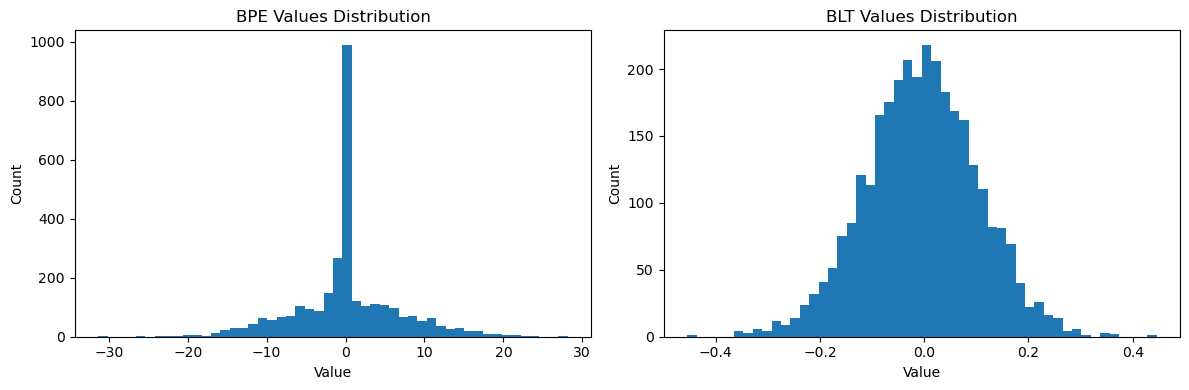

In [27]:
import duckdb
import numpy as np
from sklearn.preprocessing import StandardScaler

# Create a new connection
con = duckdb.connect('embeddings_1k.duckdb')

# Get a sample
query = """
SELECT
    embedding_blt::DOUBLE[] as blt_embedding,
    embedding_bpe::DOUBLE[] as bpe_embedding
FROM message_embeddings
LIMIT 3
"""
sample_data = con.execute(query).fetchdf()

# Convert to arrays
bpe_vectors = np.stack(sample_data['bpe_embedding'].values)
blt_vectors = np.stack(sample_data['blt_embedding'].values)

# Print detailed statistics
print("BPE Vectors:")
print("Shape:", bpe_vectors.shape)
print("Min value:", np.min(bpe_vectors))
print("Max value:", np.max(bpe_vectors))
print("Number of zeros:", np.sum(bpe_vectors == 0))
print("Unique values:", len(np.unique(bpe_vectors)))
print("\nFirst few values of first vector:", bpe_vectors[0][:10])

# Try visualizing the distribution
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(bpe_vectors.flatten(), bins=50)
plt.title('BPE Values Distribution')
plt.xlabel('Value')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(blt_vectors.flatten(), bins=50)
plt.title('BLT Values Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

con.close()

BPE dimensions after PCA: 903
BLT dimensions after PCA: 28


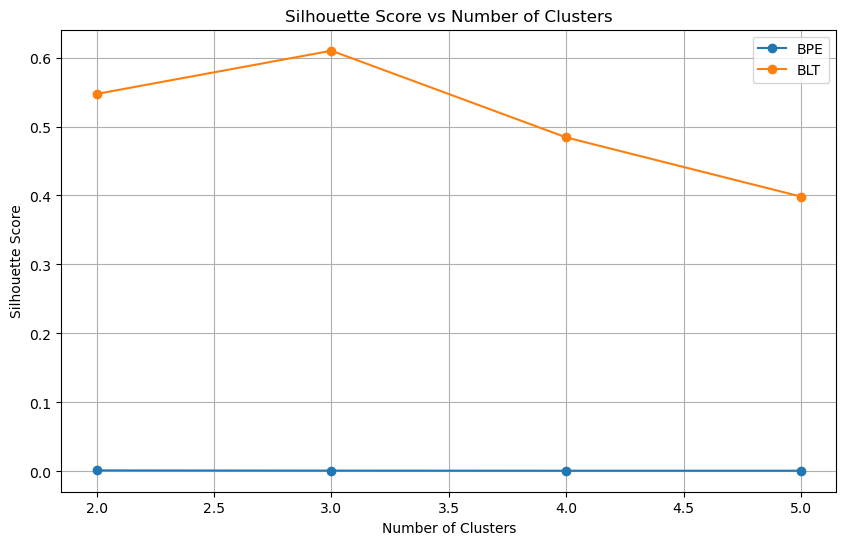

BPE Best Score: 0.0014 (n_clusters=2)
BLT Best Score: 0.6099 (n_clusters=3)


In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import duckdb

def calculate_silhouette_scores(con, n_clusters_range=range(2, 6), random_state=42, plot=True):
    """
    Calculate silhouette scores for multiple embedding vectors across different numbers of clusters.
    """
    query = """
    SELECT
        embedding_blt::DOUBLE[] as blt_embedding,
        embedding_bpe::DOUBLE[] as bpe_embedding
    FROM message_embeddings
    """
    results = con.execute(query).fetchdf()

    # Convert to numpy arrays
    bpe_vectors = np.stack(results['bpe_embedding'].values)
    blt_vectors = np.stack(results['blt_embedding'].values)
    
    # Standardize and reduce dimensionality
    scaler_bpe = StandardScaler()
    scaler_blt = StandardScaler()
    
    bpe_vectors = scaler_bpe.fit_transform(bpe_vectors)
    blt_vectors = scaler_blt.fit_transform(blt_vectors)
    
    # Apply PCA to reduce dimensionality while preserving 95% of variance
    pca_bpe = PCA(n_components=0.95, random_state=random_state)
    pca_blt = PCA(n_components=0.95, random_state=random_state)
    
    bpe_vectors = pca_bpe.fit_transform(bpe_vectors)
    blt_vectors = pca_blt.fit_transform(blt_vectors)
    
    print(f"BPE dimensions after PCA: {bpe_vectors.shape[1]}")
    print(f"BLT dimensions after PCA: {blt_vectors.shape[1]}")

    vectors_dict = {
        'BPE': bpe_vectors,
        'BLT': blt_vectors
    }

    results = {
        'scores': {name: [] for name in vectors_dict.keys()},
        'best_scores': {}
    }

    # Calculate scores for each number of clusters
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)

        for name, vectors in vectors_dict.items():
            labels = kmeans.fit_predict(vectors)
            score = silhouette_score(vectors, labels)
            results['scores'][name].append(score)

    # Find best scores
    for name in vectors_dict.keys():
        scores = results['scores'][name]
        best_score = max(scores)
        best_n_clusters = n_clusters_range[scores.index(best_score)]
        results['best_scores'][name] = {
            'score': best_score,
            'n_clusters': best_n_clusters
        }

    # Plot if requested
    if plot:
        plt.figure(figsize=(10, 6))
        for name, scores in results['scores'].items():
            plt.plot(list(n_clusters_range), scores, 'o-', label=name)

        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.legend()
        plt.grid(True)
        plt.show()

    return results

# Create DuckDB connection
con = duckdb.connect('embeddings_1k.duckdb')

# Calculate scores
results = calculate_silhouette_scores(con)

# Print best scores
for name, result in results['best_scores'].items():
    print(f"{name} Best Score: {result['score']:.4f} (n_clusters={result['n_clusters']})")

# Close connection
con.close()

## Cosine Similarity distribution

For tasks related to NLP, Cosine Similarity is preferable as a metric over Euclidian distance.

In [31]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_similarities(con, embedding_types=['bpe', 'blt'], batch_size=1000):
    """
    Calculate pairwise similarities for multiple embedding vectors from a DuckDB database.
    """
    # Get total row count
    count_query = "SELECT COUNT(*) as cnt FROM message_embeddings"
    total_rows = con.execute(count_query).fetchone()[0]

    base_query_template = """
    WITH numbered_rows AS (
        SELECT
            ROW_NUMBER() OVER () as row_id,
            embedding_{type}::DOUBLE[] as embedding
        FROM message_embeddings
        LIMIT {limit} OFFSET {offset}
    )
    SELECT
        a.row_id as id1,
        b.row_id as id2,
        (array_sum(array_multiply(a.embedding, b.embedding)) /
        (sqrt(array_sum(array_multiply(a.embedding, a.embedding))) *
         sqrt(array_sum(array_multiply(b.embedding, b.embedding))))) as cosine_similarity
    FROM numbered_rows a
    CROSS JOIN numbered_rows b
    WHERE a.row_id < b.row_id
    """

    similarities = {etype: [] for etype in embedding_types}

    with tqdm(total=total_rows, desc="Processing embeddings") as pbar:
        for offset in range(0, total_rows, batch_size):
            for etype in embedding_types:
                query = base_query_template.format(
                    type=etype,
                    limit=batch_size,
                    offset=offset
                )
                result = con.execute(query).fetch_df()
                similarities[etype].extend(result['cosine_similarity'].tolist())

            pbar.update(batch_size)

    return {k: np.array(v) for k, v in similarities.items()}

def calculate_distribution_stats(similarities):
    """
    Calculate statistical measures for a similarity distribution.
    """
    kde = stats.gaussian_kde(similarities)
    x_eval = np.linspace(similarities.min(), similarities.max(), 100)
    kde_values = kde(x_eval)
    mode_idx = np.argmax(kde_values)
    mode_value = x_eval[mode_idx]

    return {
        'n_samples': len(similarities),
        'mean': np.mean(similarities),
        'median': np.median(similarities),
        'mode': mode_value,
        'std': np.std(similarities),
        'percentile_25': np.percentile(similarities, 25),
        'percentile_75': np.percentile(similarities, 75),
        'kde': kde,
        'x_eval': x_eval,
        'kde_values': kde_values
    }

def plot_similarity_distributions(similarities_dict, figsize=(20, 7)):
    """
    Plot similarity distributions with statistics.
    """
    n_plots = len(similarities_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]

    stats_dict = {}

    for (etype, similarities), ax in zip(similarities_dict.items(), axes):
        stats = calculate_distribution_stats(similarities)
        stats_dict[etype] = stats

        # Plot KDE
        ax.plot(stats['x_eval'], stats['kde_values'], 
                color='blue', alpha=0.5)
        ax.fill_between(stats['x_eval'], stats['kde_values'], 
                       alpha=0.3, color='blue')
        
        # Add rug plot (small lines at the bottom showing data points)
        ax.plot(similarities, np.zeros_like(similarities), '|', 
                color='red', alpha=0.2, markersize=10)

        # Add statistical lines
        ax.axvline(x=stats['mode'], color='red', linestyle='--',
                  alpha=0.5, label=f'Mode: {stats["mode"]:.3f}')
        ax.axvline(x=stats['mean'], color='green', linestyle='--',
                  alpha=0.5, label=f'Mean: {stats["mean"]:.3f}')
        ax.axvline(x=stats['median'], color='blue', linestyle='--',
                  alpha=0.5, label=f'Median: {stats["median"]:.3f}')

        ax.set_title(f'{etype.upper()} Embeddings Self-Similarity Distribution')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, axes, stats_dict

def print_distribution_stats(stats_dict):
    """
    Print statistical measures for all distributions.
    """
    for etype, stats in stats_dict.items():
        print(f"\n{etype.upper()} Embeddings Distribution Statistics:")
        print(f"Number of samples: {stats['n_samples']}")
        print(f"Mean: {stats['mean']:.4f}")
        print(f"Median: {stats['median']:.4f}")
        print(f"Mode (KDE peak): {stats['mode']:.4f}")
        print(f"Standard deviation: {stats['std']:.4f}")
        print(f"25th percentile: {stats['percentile_25']:.4f}")
        print(f"75th percentile: {stats['percentile_75']:.4f}")

def analyze_embedding_similarities(con, batch_size=1000):
    """
    Complete analysis pipeline for embedding similarities.
    """
    # Calculate similarities
    similarities_dict = calculate_similarities(con, ['bpe', 'blt'], batch_size)

    # Plot distributions and calculate statistics
    fig, axes, stats_dict = plot_similarity_distributions(similarities_dict)

    # Print statistics
    print_distribution_stats(stats_dict)

    return similarities_dict, fig, axes, stats_dict

# Example usage:
# con = duckdb.connect('embeddings_1k.duckdb')
# similarities_dict, fig, axes, stats_dict = analyze_embedding_similarities(con)
# con.close()

Processing embeddings:   0%|          | 0/12169 [00:00<?, ?it/s]


BPE Embeddings Distribution Statistics:
Number of samples: 6008196
Mean: 0.0010
Median: 0.0010
Mode (KDE peak): 0.0019
Standard deviation: 0.0333
25th percentile: -0.0214
75th percentile: 0.0234

BLT Embeddings Distribution Statistics:
Number of samples: 6008196
Mean: 0.8726
Median: 0.9242
Mode (KDE peak): 0.9236
Standard deviation: 0.2174
25th percentile: 0.8861
75th percentile: 0.9648

Additional analysis for bpe:
Interquartile range: 0.0447
Range: 0.3487

Additional analysis for blt:
Interquartile range: 0.0787
Range: 1.0803


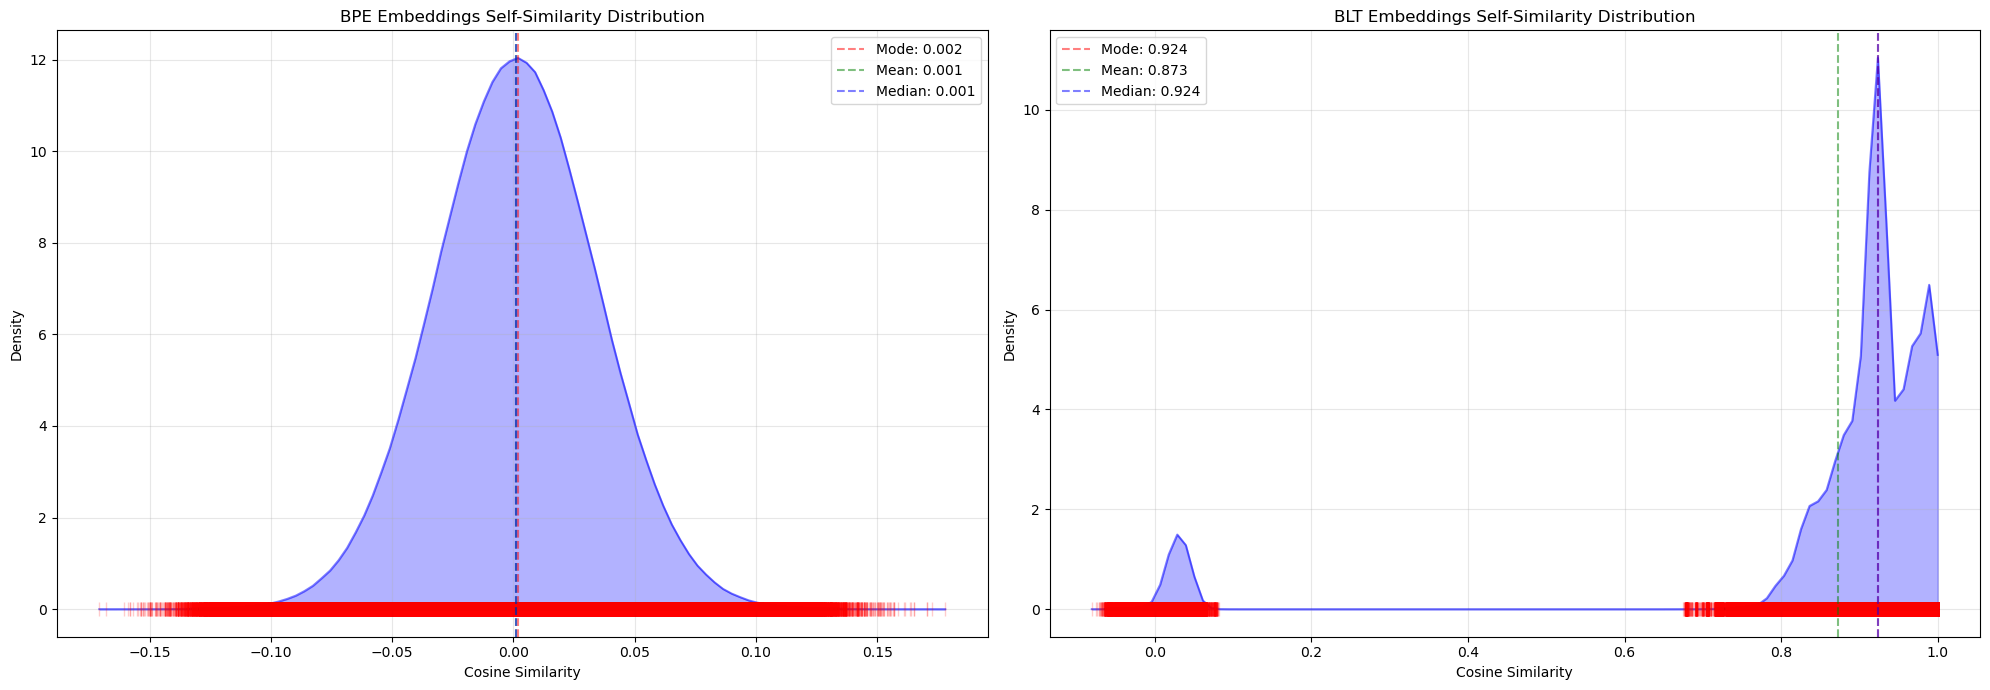

In [37]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_similarities(con, embedding_types=['bpe', 'blt'], batch_size=1000):
    """
    Calculate pairwise similarities for multiple embedding vectors from a DuckDB database.
    """
    # Get total row count
    count_query = "SELECT COUNT(*) as cnt FROM message_embeddings"
    total_rows = con.execute(count_query).fetchone()[0]

    base_query_template = """
    WITH numbered_rows AS (
        SELECT
            ROW_NUMBER() OVER () as row_id,
            embedding_{type}::DOUBLE[] as embedding
        FROM message_embeddings
        LIMIT {limit} OFFSET {offset}
    )
    SELECT
        a.row_id as id1,
        b.row_id as id2,
        (LIST_DOT_PRODUCT(a.embedding, b.embedding) /
        (SQRT(LIST_DOT_PRODUCT(a.embedding, a.embedding)) *
         SQRT(LIST_DOT_PRODUCT(b.embedding, b.embedding)))) as cosine_similarity
    FROM numbered_rows a
    CROSS JOIN numbered_rows b
    WHERE a.row_id < b.row_id
    """

    similarities = {etype: [] for etype in embedding_types}

    with tqdm(total=total_rows, desc="Processing embeddings") as pbar:
        for offset in range(0, total_rows, batch_size):
            for etype in embedding_types:
                query = base_query_template.format(
                    type=etype,
                    limit=batch_size,
                    offset=offset
                )
                result = con.execute(query).fetch_df()
                similarities[etype].extend(result['cosine_similarity'].tolist())

            pbar.update(batch_size)

    return {k: np.array(v) for k, v in similarities.items()}

def calculate_distribution_stats(similarities):
    """
    Calculate statistical measures for a similarity distribution.
    """
    kde = stats.gaussian_kde(similarities)
    x_eval = np.linspace(similarities.min(), similarities.max(), 100)
    kde_values = kde(x_eval)
    mode_idx = np.argmax(kde_values)
    mode_value = x_eval[mode_idx]

    return {
        'n_samples': len(similarities),
        'mean': np.mean(similarities),
        'median': np.median(similarities),
        'mode': mode_value,
        'std': np.std(similarities),
        'percentile_25': np.percentile(similarities, 25),
        'percentile_75': np.percentile(similarities, 75),
        'kde': kde,
        'x_eval': x_eval,
        'kde_values': kde_values
    }

def plot_similarity_distributions(similarities_dict, figsize=(20, 7)):
    """
    Plot similarity distributions with statistics.
    """
    n_plots = len(similarities_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]

    stats_dict = {}

    for (etype, similarities), ax in zip(similarities_dict.items(), axes):
        stats = calculate_distribution_stats(similarities)
        stats_dict[etype] = stats

        # Plot KDE
        ax.plot(stats['x_eval'], stats['kde_values'], 
                color='blue', alpha=0.5)
        ax.fill_between(stats['x_eval'], stats['kde_values'], 
                       alpha=0.3, color='blue')
        
        # Add rug plot (small lines at the bottom showing data points)
        ax.plot(similarities, np.zeros_like(similarities), '|', 
                color='red', alpha=0.2, markersize=10)

        # Add statistical lines
        ax.axvline(x=stats['mode'], color='red', linestyle='--',
                  alpha=0.5, label=f'Mode: {stats["mode"]:.3f}')
        ax.axvline(x=stats['mean'], color='green', linestyle='--',
                  alpha=0.5, label=f'Mean: {stats["mean"]:.3f}')
        ax.axvline(x=stats['median'], color='blue', linestyle='--',
                  alpha=0.5, label=f'Median: {stats["median"]:.3f}')

        ax.set_title(f'{etype.upper()} Embeddings Self-Similarity Distribution')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, axes, stats_dict

def print_distribution_stats(stats_dict):
    """
    Print statistical measures for all distributions.
    """
    for etype, stats in stats_dict.items():
        print(f"\n{etype.upper()} Embeddings Distribution Statistics:")
        print(f"Number of samples: {stats['n_samples']}")
        print(f"Mean: {stats['mean']:.4f}")
        print(f"Median: {stats['median']:.4f}")
        print(f"Mode (KDE peak): {stats['mode']:.4f}")
        print(f"Standard deviation: {stats['std']:.4f}")
        print(f"25th percentile: {stats['percentile_25']:.4f}")
        print(f"75th percentile: {stats['percentile_75']:.4f}")

def analyze_embedding_similarities(con, batch_size=1000):
    """
    Complete analysis pipeline for embedding similarities.
    """
    # Calculate similarities
    similarities_dict = calculate_similarities(con, ['bpe', 'blt'], batch_size)

    # Plot distributions and calculate statistics
    fig, axes, stats_dict = plot_similarity_distributions(similarities_dict)

    # Print statistics
    print_distribution_stats(stats_dict)

    return similarities_dict, fig, axes, stats_dict

# Create a new connection
con = duckdb.connect('embeddings_1k.duckdb')

# Analyze embedding similarities with default parameters (BPE and BLT)
similarities_dict, fig, axes, stats_dict = analyze_embedding_similarities(
    con=con,
    batch_size=1000
)

# The plot will be automatically displayed due to the function
# If you want to save the figure, you can do:
# fig.savefig('embedding_similarities.png', dpi=300, bbox_inches='tight')

# The statistics are already printed by the function, but you can access them directly:
# Access specific statistics for each embedding type
for etype, stats in stats_dict.items():
    print(f"\nAdditional analysis for {etype}:")
    print(f"Interquartile range: {stats['percentile_75'] - stats['percentile_25']:.4f}")
    print(f"Range: {similarities_dict[etype].max() - similarities_dict[etype].min():.4f}")

# You can also access the raw similarity values if needed:
bpe_similarities = similarities_dict['bpe']
blt_similarities = similarities_dict['blt']

# Close the connection
con.close()

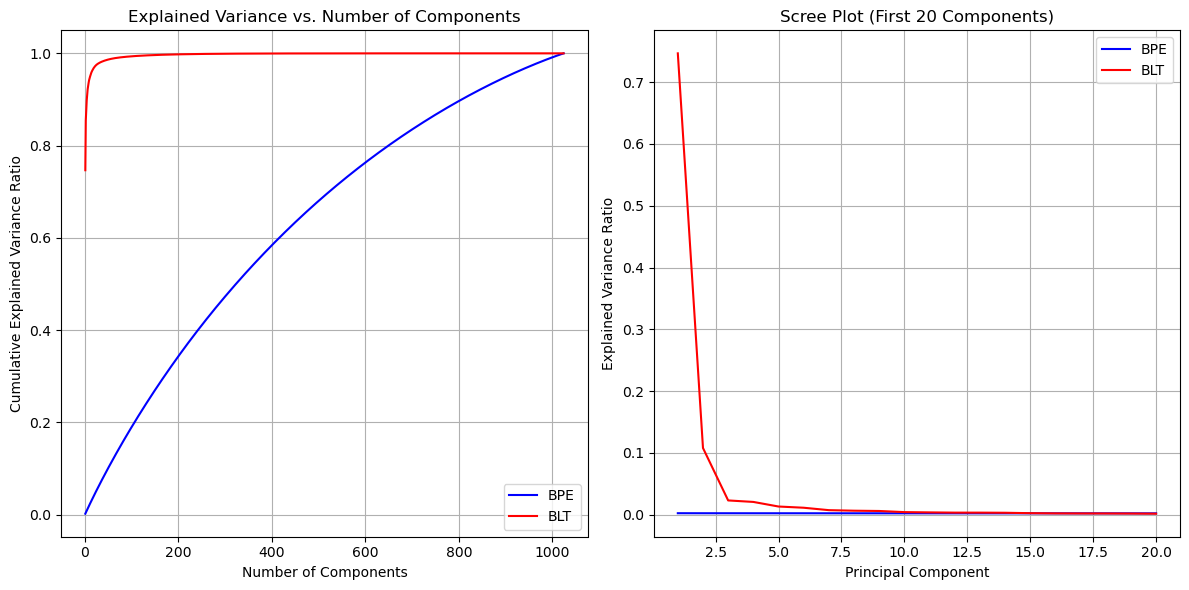


BPE Statistics:
Original dimensions: 1024
Components needed for 80.0% variance: 650
Components needed for 90.0% variance: 806
Components needed for 95.0% variance: 903
Components needed for 99.0% variance: 997

BLT Statistics:
Original dimensions: 1024
Components needed for 80.0% variance: 650
Components needed for 90.0% variance: 806
Components needed for 95.0% variance: 903
Components needed for 99.0% variance: 997


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import duckdb

# Create connection and get embeddings
con = duckdb.connect('embeddings_1k.duckdb')

# Get embeddings
query = """
SELECT 
    embedding_bpe::DOUBLE[] as bpe_embedding,
    embedding_blt::DOUBLE[] as blt_embedding
FROM message_embeddings
"""
results = con.execute(query).fetch_df()

# Convert to numpy arrays
bpe_vectors = np.stack(results['bpe_embedding'].values)
blt_vectors = np.stack(results['blt_embedding'].values)

# Calculate PCA for both
pca_bpe = PCA()
pca_blt = PCA()

pca_bpe.fit(bpe_vectors)
pca_blt.fit(blt_vectors)

# Calculate cumulative explained variance
cum_var_exp_bpe = np.cumsum(pca_bpe.explained_variance_ratio_)
cum_var_exp_blt = np.cumsum(pca_blt.explained_variance_ratio_)

# Plot
plt.figure(figsize=(12, 6))

# Plot cumulative explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cum_var_exp_bpe) + 1), cum_var_exp_bpe, 'b-', label='BPE')
plt.plot(range(1, len(cum_var_exp_blt) + 1), cum_var_exp_blt, 'r-', label='BLT')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()

# Plot individual explained variance (elbow plot)
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), pca_bpe.explained_variance_ratio_[:20], 'b-', label='BPE')
plt.plot(range(1, 21), pca_blt.explained_variance_ratio_[:20], 'r-', label='BLT')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot (First 20 Components)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
for name, pca, vectors in [('BPE', pca_bpe, bpe_vectors), ('BLT', pca_blt, blt_vectors)]:
    print(f"\n{name} Statistics:")
    print(f"Original dimensions: {vectors.shape[1]}")
    
    # Number of components needed for different variance thresholds
    for threshold in [0.8, 0.9, 0.95, 0.99]:
        n_components = np.argmax(cum_var_exp_bpe >= threshold) + 1
        print(f"Components needed for {threshold*100}% variance: {n_components}")

con.close()